# Libraries & Analysis Set Up

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import statsmodels.api as sm


# **Data Preparation and Wrangling**

### Alcohol Policies

In [17]:
df_alcohol = pd.read_csv("COVID-19 Alcohol.csv")
df_alcohol = df_alcohol[['State Abbreviation','Alcohol/Liquor Stores Open', 'Keep Firearms Sellers Open']].copy()

### Face Masks Policies

In [18]:
df_face_mask = pd.read_csv("COVID-19 Face Masks.csv")

df_face_mask['start_date'] = pd.to_datetime(df_face_mask['Public face mask mandate start'], errors='coerce')
df_face_mask['end_date'] = pd.to_datetime(df_face_mask['Face mask mandate end'], errors='coerce')

latest_date = df_face_mask['end_date'].max()

# Calculate the duration of the face mask mandate
def get_duration(row):
    start = row['start_date']
    end = row['end_date']

    # If no start date, duration is 0
    if pd.isna(start):
        return 0
    # If start exists but no end date, assume it lasted until the latest date
    if pd.isna(end):
        end = latest_date
        
    return (end - start).days

# Generate a socring system for pro mask face policies
def calculate_mask_score(row):
    score = 0
    
    if str(row['Public face mask mandate start']) != '0':
        score += 1
    if row['Face mask mandate enforced by fines'] == 1:
        score += 1
    if row['Face mask mandate enforced by criminal charge/citation'] == 1:
        score += 1
    if str(row['Business face mask mandate start']) != '0':
        score += 1
        
    if row['No legal enforcement of face mask mandate'] == 1:
        score -= 1
    if str(row['Banned school face mask mandates']) != '0':
        score -= 1
    if str(row['Banned other local face mask mandates']) != '0':
        score -= 1
        
    return score


df_face_mask['Face_Mask_Mandate_Duration_Days'] = df_face_mask.apply(get_duration, axis=1)
df_face_mask['Pro_Mask_Score'] = df_face_mask.apply(calculate_mask_score, axis=1)

### Stay At Home Policies

In [19]:
df_stay_home = pd.read_csv("COVID-19 Stay At Home.csv")

df_stay_home['start_date'] = pd.to_datetime(df_stay_home['Stay at home/shelter in place'], errors='coerce')
df_stay_home['end_date'] = pd.to_datetime(df_stay_home['End stay at home/shelter in place '], errors='coerce')

earliest_date = df_stay_home['start_date'].min()
latest_date = df_stay_home['end_date'].max()

df_stay_home['Stay_at_Home_Duration_Days'] = df_stay_home.apply(get_duration, axis=1)

df_stay_home = df_stay_home[
    ['State Abbreviation','Stay at home/shelter in place','End stay at home/shelter in place ',
      'start_date', 'end_date', 'Stay_at_Home_Duration_Days']
      ].copy()

### Food And Beverage sales

In [20]:
df_sales = pd.read_csv("Food-&-Beverage-stores.csv")

# rename to readable state abbreviations
df_sales.rename(columns=lambda x: x[4:6] if x.startswith('MSRS') else x, inplace=True)

# Categorize and cluster the periods into covid labels
df_sales['observation_date'] = pd.to_datetime(df_sales['observation_date'], errors='coerce')

def categorize_period(date):
    if date < pd.to_datetime('2020-03-01'): return 'Pre-COVID'
    elif date < pd.to_datetime('2021-01-01'): return 'Panic Phase'
    elif date < pd.to_datetime('2022-01-01'): return 'Adjustment Phase'
    else: return 'Post-COVID'

df_sales['Period'] = df_sales['observation_date'].apply(categorize_period)

# Average the sales accross the periods
df_final = df_sales.groupby('Period').mean(numeric_only=True).T.reset_index()

df_final.rename(columns={'index': 'State Abbreviation'}, inplace=True)

cols_order = ['State Abbreviation', 'Pre-COVID', 'Panic Phase', 'Adjustment Phase', 'Post-COVID']
df_sales_final = df_final[cols_order]

# **COIVD Impact on sales**

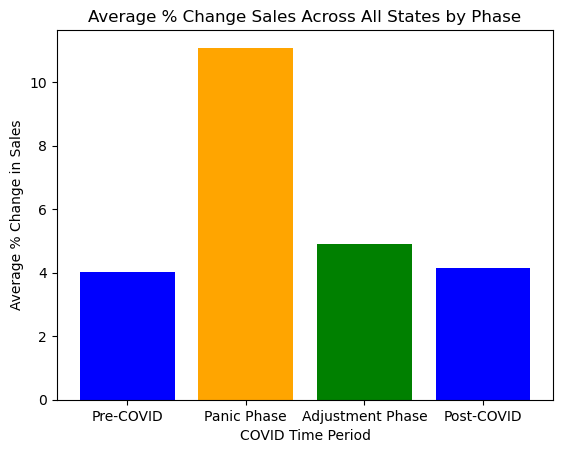

In [21]:
df_sales_national = df_sales_final[
    ['Pre-COVID','Panic Phase', 'Adjustment Phase', 'Post-COVID']
    ].mean()

plt.bar(df_sales_national.index, df_sales_national.values, color=['blue', 'orange', 'green'])

plt.xlabel('COVID Time Period')
plt.ylabel('Average % Change in Sales')
plt.title('Average % Change Sales Across All States by Phase')

# Show the plot
plt.show()



Sales during COVID (in the panic phase) spiked significantly to more than %10 compared to the stability in other periods, which is likely due to panic buying and stockpiling of goods as people prepared for lockdowns and uncertainty. The Adjustment Phase was more than the other phases slightly as the likely the panic in the population almost, but not entirely, disappered.

Text(95.72222222222221, 0.5, 'State')

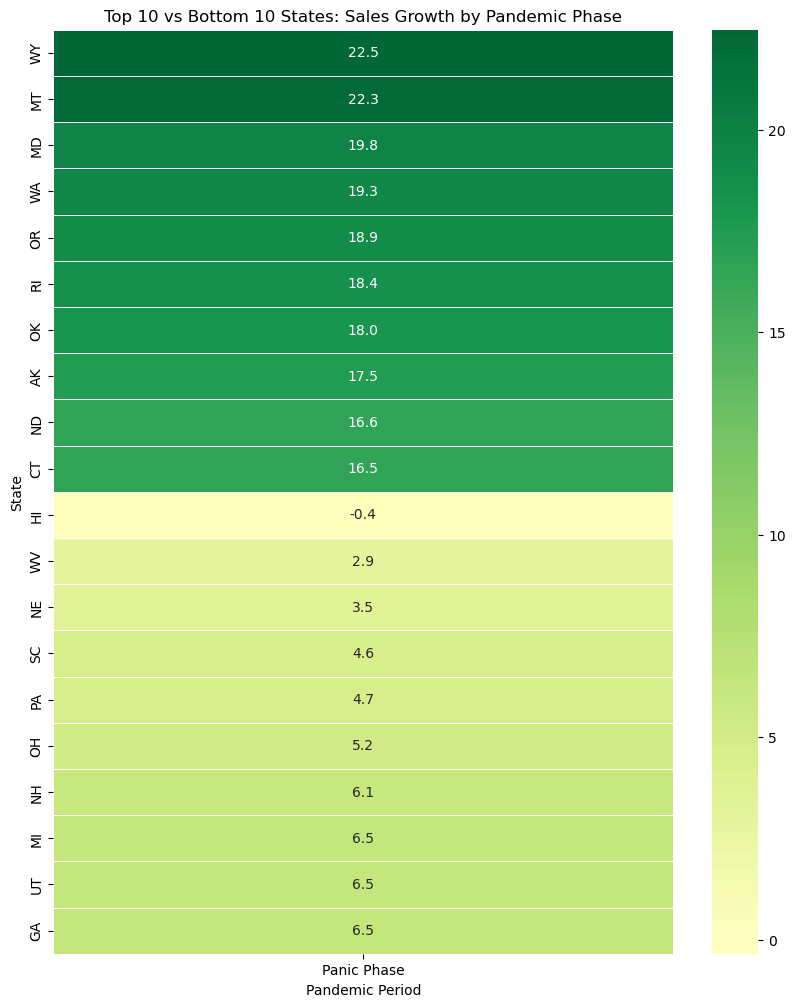

In [22]:
top_states_covid = df_sales_final[['State Abbreviation','Panic Phase']
               ].sort_values(by = 'Panic Phase',ascending=False)[:10]

lowest_states_covid = df_sales_final[['State Abbreviation','Panic Phase']
               ].sort_values(by = 'Panic Phase')[:10]

heatmap_filtered = pd.concat([top_states_covid, lowest_states_covid])

plt.figure(figsize=(10, 12)) 
sns.heatmap(heatmap_filtered.set_index('State Abbreviation'), annot=True, cmap='RdYlGn', center=0, fmt=".1f", linewidths=.5)
plt.title('Top 10 vs Bottom 10 States: Sales Growth by Pandemic Phase')
plt.xlabel('Pandemic Period')
plt.ylabel('State')

The graphs show that most states experienced higher sales percentage changes during the pandemic's "Panic Phase" compared to the average sales change of around 4% observed in other periods. The top 10 states, led by Wyoming (22.5%) Montana (22.3%) Maryland (%19.8) and Washington (19.3%), saw significantly higher sales growth, while the bottom 10 states, including Hawaii (-0.4%) and West Virginia (2.9%), had modest or even negative changes. Notably, only a few states, like Hawaii, fell below the average, highlighting that the pandemic phase generally drove increased sales across the majority of states.

# **COIVD Policies Impact On Sales**

In [23]:
df_policies = pd.merge(df_face_mask[['State Abbreviation','Face_Mask_Mandate_Duration_Days','Pro_Mask_Score']], 
                       df_stay_home[['State Abbreviation','Stay_at_Home_Duration_Days']], 
                       on='State Abbreviation', 
                       how='outer')

df_policies = pd.merge(df_policies, 
                       df_alcohol, 
                       on='State Abbreviation', 
                       how='outer')
df_policies.head()

,State Abbreviation,Face_Mask_Mandate_Duration_Days,Pro_Mask_Score,Stay_at_Home_Duration_Days,Alcohol/Liquor Stores Open,Keep Firearms Sellers Open
0,AK,28,4,27,1,1
1,AL,267,1,26,1,1
2,AR,253,2,0,1,1
3,AZ,0,-2,46,1,1
4,CA,607,1,312,1,0


## OLS Regression Model

In [24]:
# Combining sales with policies
df = df_policies.merge(df_sales_final[['State Abbreviation','Adjustment Phase']], on = 'State Abbreviation')
df.dropna(inplace = True)

# Defining the Independent and dependent features for the multi linear regression model
X = df[
    ['Face_Mask_Mandate_Duration_Days','Pro_Mask_Score','Stay_at_Home_Duration_Days',
     'Alcohol/Liquor Stores Open','Keep Firearms Sellers Open']
     ]
Y = df['Adjustment Phase']

# Add y intercept
X = sm.add_constant(X)

# Run the model
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Adjustment Phase   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                    0.3127
Date:                Thu, 15 Jan 2026   Prob (F-statistic):              0.903
Time:                        14:26:03   Log-Likelihood:                -169.85
No. Observations:                  49   AIC:                             351.7
Df Residuals:                      43   BIC:                             363.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

## Spearman Correlation (non-linear relationship)

In [25]:
# Spearman Correlation
df = df_policies.merge(df_sales_final[['State Abbreviation','Adjustment Phase']], on = 'State Abbreviation')

# Drop state abbreviation (non-numeric)
df_corr = df.drop(columns=['State Abbreviation'])

df_corr.isna().mean()
spearman_corr = df_corr.corr(method='spearman')
spearman_corr

,Face_Mask_Mandate_Duration_Days,Pro_Mask_Score,Stay_at_Home_Duration_Days,Alcohol/Liquor Stores Open,Keep Firearms Sellers Open,Adjustment Phase
Face_Mask_Mandate_Duration_Days,1.000000,0.668003,0.597887,-0.298264,-0.398262,0.031615
Pro_Mask_Score,0.668003,1.000000,0.464172,-0.134964,-0.129778,-0.064256
Stay_at_Home_Duration_Days,0.597887,0.464172,1.000000,-0.149360,-0.493227,-0.047426
Alcohol/Liquor Stores Open,-0.298264,-0.134964,-0.149360,1.000000,0.238696,-0.262557
Keep Firearms Sellers Open,-0.398262,-0.129778,-0.493227,0.238696,1.000000,0.008805
Adjustment Phase,0.031615,-0.064256,-0.047426,-0.262557,0.008805,1.000000


There is no strong correlation between pandemic policies and state-level sales impact. Mask mandates, pro-mask scores, and stay-at-home duration all show near-zero relationships with sales, indicating minimal effect. Keeping alcohol/liquor stores open has a weak negative correlation (−0.26), suggesting a small association with poorer sales adjustment, but overall policy differences explain very little of the variation in sales outcomes across states.

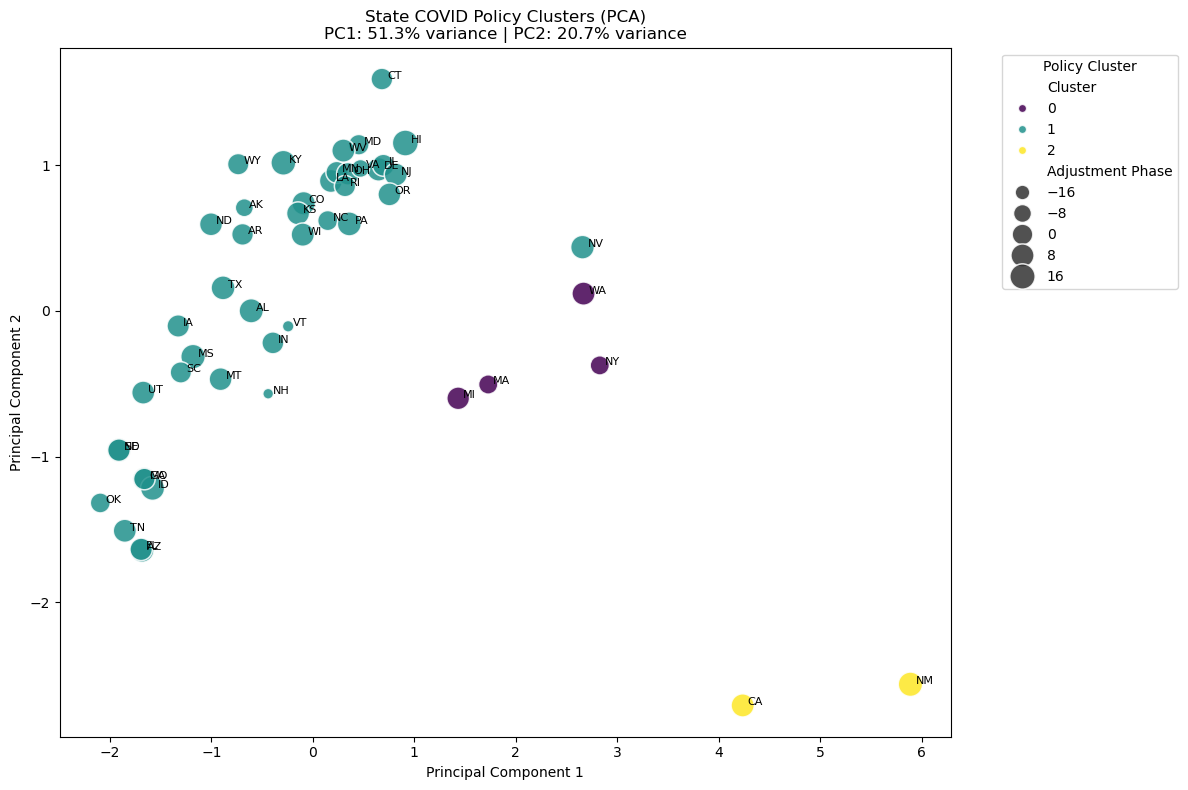

In [ ]:
# Define the variables
features = ['Face_Mask_Mandate_Duration_Days', 'Pro_Mask_Score', 
            'Stay_at_Home_Duration_Days', 'Alcohol/Liquor Stores Open', 
            'Keep Firearms Sellers Open']

df_pca = df.dropna(subset=features + ['Adjustment Phase']).copy()
X = df_pca[features]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce the features to two components 
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
df_pca['PC1'] = principal_components[:, 0]
df_pca['PC2'] = principal_components[:, 1]

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(X_scaled)
df_pca['Cluster_Label'] = df_pca['Cluster'].astype(str)

#Viualization
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_pca,
    x='PC1',
    y='PC2',
    hue='Cluster',
    size='Adjustment Phase',
    sizes=(60, 350),
    palette='viridis',
    alpha=0.85
)

# Annotate state abbreviations
for _, row in df_pca.iterrows():
    plt.text(
        row['PC1'] + 0.05,
        row['PC2'],
        row['State Abbreviation'],
        fontsize=8
    )
plt.title(f"State COVID Policy Clusters (PCA)\n"
          f"PC1: {pca.explained_variance_ratio_[0]*100:.1f}% variance | "
          f"PC2: {pca.explained_variance_ratio_[1]*100:.1f}% variance"
          )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.legend(title="Policy Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


This plot shows that states didn’t follow one simple COVID policy path. Instead, they grouped into a few clear policy styles. The first PCA axis reflects how strict policies were overall, while the second captures how those policies were implemented. States with especially long and strict restrictions, like California and New Mexico, stand apart and show larger sales disruptions, while most states fall into a more moderate group with mixed outcomes. This helps explain why the regression and Spearman results didn’t find a strong linear nor nonlinear relationship

# **Seasonal & Regional Patterns**

In [29]:
if 'Period' in df_sales.columns:
    df_sales = df_sales.drop(columns='Period')

df_melted = df_sales.melt(id_vars=['observation_date'], var_name='State', value_name='Pct_Change')
df_melted['observation_date'] = pd.to_datetime(df_melted['observation_date'])
df_melted['Month'] = df_melted['observation_date'].dt.month

state_to_region = {
    # Northeast
    'CT':'Northeast','ME':'Northeast','MA':'Northeast','NH':'Northeast',
    'RI':'Northeast','VT':'Northeast','NJ':'Northeast','NY':'Northeast','PA':'Northeast',

    # Midwest
    'IL':'Midwest','IN':'Midwest','MI':'Midwest','OH':'Midwest','WI':'Midwest',
    'IA':'Midwest','KS':'Midwest','MN':'Midwest','MO':'Midwest','NE':'Midwest',
    'ND':'Midwest','SD':'Midwest',

    # South
    'AL':'South','AR':'South','DE':'South','FL':'South','GA':'South','KY':'South',
    'LA':'South','MD':'South','MS':'South','NC':'South','OK':'South','SC':'South',
    'TN':'South','TX':'South','VA':'South','WV':'South',

    # West
    'AK':'West','AZ':'West','CA':'West','CO':'West','HI':'West','ID':'West',
    'MT':'West','NV':'West','NM':'West','OR':'West','UT':'West','WA':'West','WY':'West'
}

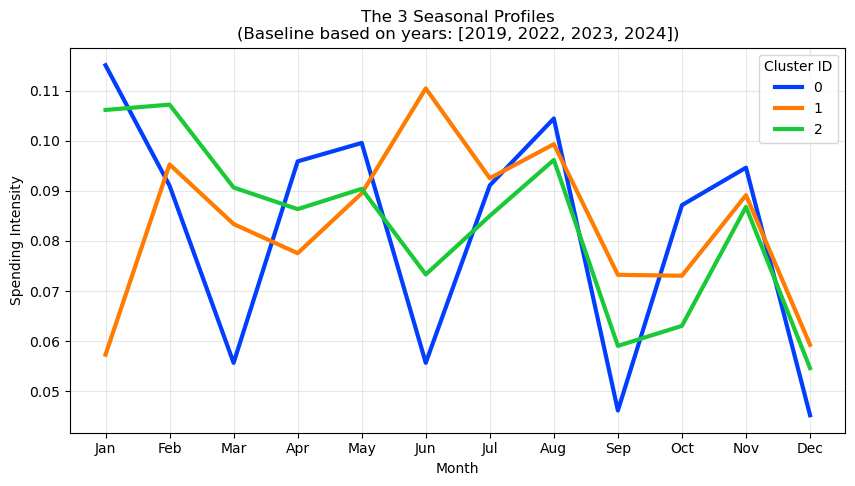


Cluster 0 States:
AR, AZ, CA, CO, MA, MS, NY, OR, PA

Cluster 1 States:
AL, ID, IN, KY, ME, MI, NC, NH, OH, RI, SC, TN, UT, VA, VT, WV

Cluster 2 States:
AK, CT, DE, FL, GA, HI, IA, IL, KS, LA, MD, MN, MO, MT, ND, NE, NJ, NM, NV, OK, SD, TX, WA, WI, WY


In [44]:
# Filter stable years and aggregate seasonality
stable_years = [2019, 2022, 2023, 2024]

df_stable = df_melted[df_melted['observation_date'].dt.year.isin(stable_years)]

seasonal_matrix = (
    df_stable
    .groupby(['State', 'Month'])['Pct_Change']
    .mean()
    .unstack()
)

# Drop states with missing months
X = seasonal_matrix.dropna()
X.index.name = 'State'

# Normalize by total absolute movement (keeps shape, removes magnitude)
X_norm = X.div(X.abs().sum(axis=1), axis=0)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_norm)

# Assign the cluster labels back to the stable dataset for plotting
X_norm['Cluster'] = kmeans.labels_

# Visualize
df_plot = (
    X_norm.reset_index()
     .melt(id_vars=['State', 'Cluster'], 
           var_name='Month', 
           value_name='Seasonal_Index')
)


plt.figure(figsize=(10, 5))
sns.lineplot(data=df_plot, x='Month', y='Seasonal_Index', hue='Cluster', 
             palette='bright', linewidth=3, errorbar=None)

plt.title(f'The 3 Seasonal Profiles\n(Baseline based on years: {stable_years})')
plt.ylabel('Spending Intensity')
plt.xlabel('Month')
plt.xticks(range(1, 13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()

for i in range(3):
    print(f"\nCluster {i} States:")
    print(", ".join(X_norm[X_norm['Cluster'] == i].index.tolist()))


In [31]:
cluster_geo = (
    X_norm[['Cluster']]
    .reset_index()
)

cluster_geo['Region'] = cluster_geo['State'].map(state_to_region)

# Count states per Region × Cluster
cluster_region_summary = (
    cluster_geo
    .groupby(['Region', 'Cluster'])
    .size()
    .unstack(fill_value=0)
)
for c in sorted(cluster_geo['Cluster'].unique()):
    print(f"\nCluster {c}:")
    print(
        cluster_geo[cluster_geo['Cluster'] == c]
        .groupby('Region')['State']
        .count()
        .sort_values(ascending=False)
    )


Cluster 0:
Region
West         4
Northeast    3
South        2
Name: State, dtype: int64

Cluster 1:
Region
South        7
Northeast    4
Midwest      3
West         2
Name: State, dtype: int64

Cluster 2:
Region
Midwest      9
South        7
West         7
Northeast    2
Name: State, dtype: int64


States do share similar seasonal consumption patterns, but these patterns don’t line up neatly with geography. Each cluster includes states from multiple regions, showing that no single region dominates a seasonal profile. While the South appears more often in one cluster and the Midwest in another, overall the clusters are geographically mixed. This suggests that seasonal consumption behavior is influenced more by shared economic or consumer trends than by region alone.

In [32]:
# Helper to get Matrix
def get_matrix(df, year):
    # Filter by year
    d = df[df['observation_date'].dt.year == year]
    # Pivot
    return d.pivot_table(index='State', columns='Month', values='Pct_Change', aggfunc='mean').fillna(0)

X_2019 = get_matrix(df_melted, 2019)
X_2024 = get_matrix(df_melted, 2024)

X_2019_std = X_2019.sub(X_2019.mean(axis=1), axis=0)\
                  .div(X_2019.std(axis=1), axis=0)

X_2024_std = X_2024.sub(X_2024.mean(axis=1), axis=0)\
                  .div(X_2024.std(axis=1), axis=0)

# Calculate Metrics
# Ensure states exist in both years
common = X_2019.index.intersection(X_2024.index)
X_2019, X_2024 = X_2019.loc[common], X_2024.loc[common]

# Calculate Pattern Shift (Euclidean Distance on Raw % Data)
# Did the ups and downs happen in different months?
seasonal_shift = np.linalg.norm(X_2019_std.values - X_2024_std.values,axis=1)

# Calculate 2024 Performance (Average Growth Rate)
# Is the state generally growing or shrinking in 2024?
avg_growth_2019 = X_2019.mean(axis=1)
avg_growth_2024 = X_2024.mean(axis=1)

level_ratio = avg_growth_2024 / avg_growth_2019

# Combine & Categorize
analysis = pd.DataFrame({
    'State': common,
    'Seasonal_Shift': seasonal_shift,
    'Avg_2019_Growth': avg_growth_2019.values,
    'Avg_2024_Growth': avg_growth_2024.values,
    'Change_Ratio' : level_ratio
})

def categorize(row):
    if row['Avg_2024_Growth'] > row['Avg_2019_Growth']:
        return "New Normal (Growth)" 
    else:
        return "Struggling (Decline)"

analysis['Category'] = analysis.apply(categorize, axis=1)

# Filter for Shifter
non_recovered = analysis[
    (analysis['Seasonal_Shift'] > analysis['Seasonal_Shift'].quantile(0.8)) &
    (analysis['Avg_2024_Growth'] < analysis['Avg_2019_Growth'])
]
print(f"number of States that Didn't Recover: {len(non_recovered)}")
print()
non_recovered.sort_values('Change_Ratio', ascending = False)

number of States that Didn't Recover: 7



,State,Seasonal_Shift,Avg_2019_Growth,Avg_2024_Growth,Change_Ratio,Category
State,,,,,,
AK,AK,5.943658,2.325000,1.566667,0.673835,Struggling (Decline)
AL,AL,5.416827,5.066667,2.800000,0.552632,Struggling (Decline)
HI,HI,5.457941,5.691667,2.625000,0.461201,Struggling (Decline)
DE,DE,5.450033,2.600000,1.175000,0.451923,Struggling (Decline)
NJ,NJ,6.125261,2.750000,1.241667,0.451515,Struggling (Decline)
OH,OH,5.530079,3.358333,0.583333,0.173697,Struggling (Decline)
WV,WV,5.496022,3.850000,0.308333,0.080087,Struggling (Decline)


In [33]:
non_recovered_geo = non_recovered.copy()
non_recovered_geo['Region'] = non_recovered_geo['State'].map(state_to_region)

non_recovered_region_summary = (
    non_recovered_geo
    .groupby('Region')
    .size()
    .sort_values(ascending=False)
)

print("Regions with states that did NOT recover post-COVID:")
display(non_recovered_region_summary)

Regions with states that did NOT recover post-COVID:


Region
South        3
West         2
Midwest      1
Northeast    1
dtype: int64

States like Alaska, Ohio, and Hawaii did not recover from COIVD with some even having sales growth less by half compared to pre-COIVD sales growth

# **Forecasting First Half of 2025**

## Seasonal Baseline Forecasting

In [34]:
# Prepare the Data
# Stable years
stable_years = [2019, 2022, 2023, 2024]

# Filter WA + stable years
wa = df_melted[
    (df_melted['State'] == 'WA') &
    (df_melted['observation_date'].dt.year.isin(stable_years))
].copy()

wa['Month'] = wa['observation_date'].dt.month
wa['Year'] = wa['observation_date'].dt.year

In [35]:
wa_seasonality = (
    wa.groupby('Month')['Pct_Change']
      .mean()
)
wa_seasonality

Month
1     4.875
2     4.750
3     3.650
4     4.025
5     4.150
6     3.275
7     3.575
8     4.700
9     2.850
10    3.375
11    3.450
12    2.050
Name: Pct_Change, dtype: float64

In [36]:
# Last observed month in dataset
last_month = wa['observation_date'].max().month

# Generate next 6 months
forecast_months = [(last_month + i - 1) % 12 + 1 for i in range(1, 7)]

forecast = pd.DataFrame({
    'Month': forecast_months,
    'Forecast_Pct_Change': wa_seasonality.loc[forecast_months].values
})

forecast['Month_Name'] = forecast['Month'].map({
    1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
    7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'
})

forecast

,Month,Forecast_Pct_Change,Month_Name
0,1,4.875,Jan
1,2,4.750,Feb
2,3,3.650,Mar
3,4,4.025,Apr
4,5,4.150,May
5,6,3.275,Jun


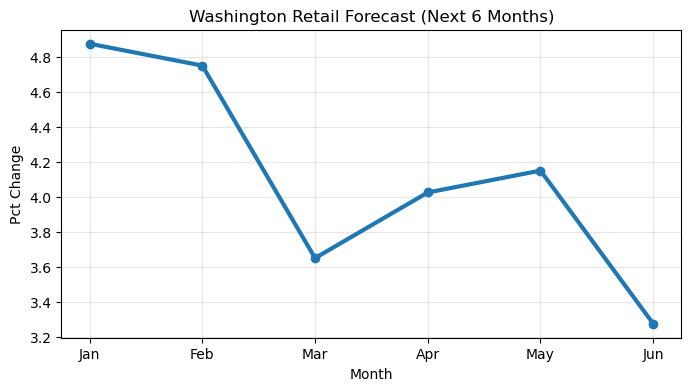

In [37]:
# Visalize the forecast
forecast_months = [1, 2, 3, 4, 5, 6]

wa_6mo = wa_seasonality.loc[forecast_months]

plt.figure(figsize=(8, 4))
plt.plot(
    wa_6mo.index,
    wa_6mo.values,
    marker='o',
    linewidth=3
)

plt.title("Washington Retail Forecast (Next 6 Months)")
plt.ylabel("Pct Change")
plt.xlabel("Month")
plt.xticks(
    forecast_months,
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
)
plt.grid(alpha=0.3)
plt.show()

In [38]:
seasonal_stats = (
    wa.groupby('Month')['Pct_Change']
      .agg(['mean', 'std'])
      .reset_index()
)
seasonal_stats

,Month,mean,std
0,1,4.875,2.978115
1,2,4.750,3.535062
2,3,3.650,4.801736
3,4,4.025,5.571580
4,5,4.150,3.437538
5,6,3.275,4.973513
6,7,3.575,4.407853
7,8,4.700,5.987209
8,9,2.850,3.148015
9,10,3.375,4.654299


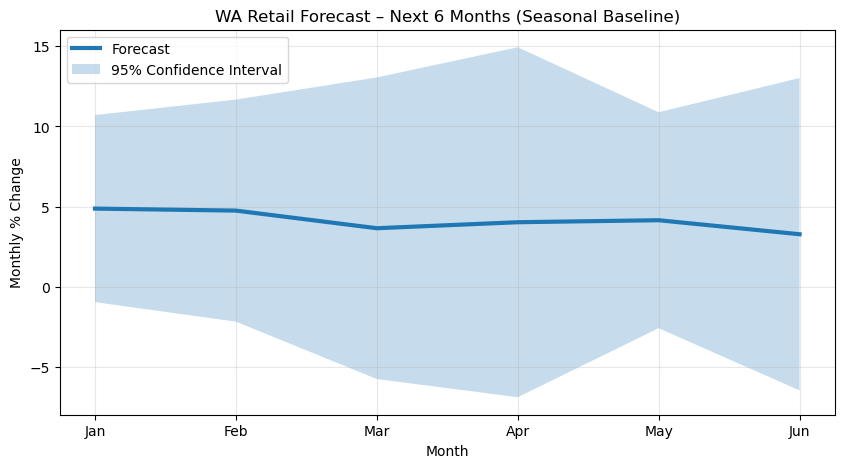

In [39]:
# Caluclating the Confidence Interval
forecast_months = seasonal_stats.iloc[:6].copy()

z = 1.96  # 95% CI
forecast_months['lower'] = forecast_months['mean'] - (z * forecast_months['std'])
forecast_months['upper'] = forecast_months['mean'] + (z * forecast_months['std'])

# Visualizae 
plt.figure(figsize=(10, 5))
plt.plot(forecast_months['Month'], forecast_months['mean'], label='Forecast', linewidth=3)
plt.fill_between(
    forecast_months['Month'],
    forecast_months['lower'],
    forecast_months['upper'],
    alpha=0.25,
    label='95% Confidence Interval'
)

plt.xticks(range(1, 7), ['Jan','Feb','Mar','Apr','May','Jun'])
plt.title('WA Retail Forecast – Next 6 Months (Seasonal Baseline)')
plt.ylabel('Monthly % Change')
plt.xlabel('Month')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [40]:
# Measuring the accuracy of the forecast
# Actual 2024 WA data
wa_2024 = wa[wa['Year'] == 2024].groupby('Month')['Pct_Change'].mean()

# Align predictions
pred_2024 = wa_seasonality.loc[wa_2024.index]

# Mean Absolute Error
mae = np.mean(np.abs(wa_2024 - pred_2024))

# Directional Accuracy
directional_accuracy = np.mean(
    np.sign(wa_2024) == np.sign(pred_2024)
)

mae, directional_accuracy

(0.9145833333333334, 0.9166666666666666)

## Prophet Model Forecasting

In [41]:
# Prepare Data for Prophet
df_prophet = df_melted[df_melted['State'] == 'WA'].copy()
df_prophet = df_prophet[['observation_date', 'Pct_Change']].rename(columns={'observation_date': 'ds', 'Pct_Change': 'y'})

# Train the model
train_df = df_prophet[
    (~df_prophet['ds'].dt.year.isin([2020, 2021])) & 
    (df_prophet['ds'].dt.year < 2024)
]

# fit the model
model = Prophet(seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(train_df)

# predict 2024
future_2024 = pd.DataFrame({'ds': pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')})
forecast = model.predict(future_2024)

# compare predicted and actual 2024
# Get Actuals
actual_2024 = df_prophet[df_prophet['ds'].dt.year == 2024].sort_values('ds')['y'].values
# Get Predictions
pred_prophet = forecast['yhat'].values

# Calculate Metrics
mae_prophet = mean_absolute_error(actual_2024, pred_prophet)
dir_acc_prophet = np.mean(np.sign(actual_2024) == np.sign(pred_prophet))

# Print accuracy
print("")
print("Model's accuracy:")
print("Prophet Model MAE:", mae_prophet)

14:28:29 - cmdstanpy - INFO - Chain [1] start processing
14:28:30 - cmdstanpy - INFO - Chain [1] done processing



Model's accuracy:
Prophet Model MAE: 4.375427883066224


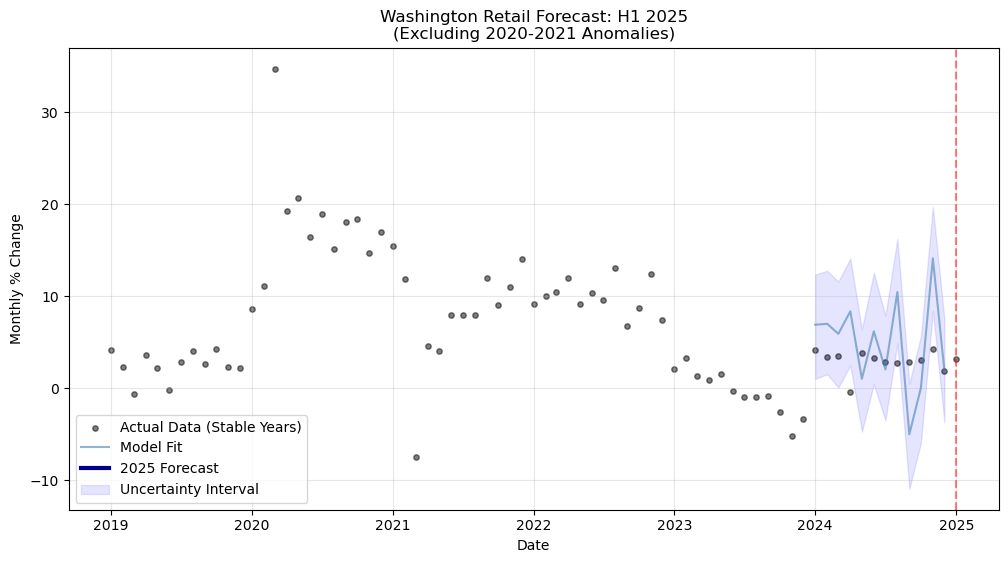

In [42]:
#Visualization
plt.figure(figsize=(12, 6))

plt.scatter(df_prophet['ds'], df_prophet['y'], color='black', alpha=0.5, s=15, label='Actual Data (Stable Years)')

past_fit = forecast[forecast['ds'] <= df_prophet['ds'].max()]
plt.plot(past_fit['ds'], past_fit['yhat'], color='steelblue', alpha=0.6, label='Model Fit')

# Forecast line (bold)
future_forecast = forecast[forecast['ds'] > df_prophet['ds'].max()]
plt.plot(future_forecast['ds'], future_forecast['yhat'], color='darkblue', linewidth=3, label='2025 Forecast')

# Confidence interval
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='blue', alpha=0.1, label='Uncertainty Interval')

plt.axvline(df_prophet['ds'].max(), color='red', linestyle='--', alpha=0.5)
plt.title("Washington Retail Forecast: H1 2025\n(Excluding 2020-2021 Anomalies)")
plt.xlabel("Date")
plt.ylabel("Monthly % Change")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Model Evaluation & Selection

I ran a showdown between the advanced Facebook Prophet model and a simple historical baseline, and the results were clear: simpler was better. The Prophet model got 'confused' by the chaos of 2022 and 2023, predicting that 2024 would be just as volatile. It wasn't. The market stabilized, and the simple baseline caught that trend perfectly, beating the complex model’s accuracy by a landslide (MAE 0.91 vs. 4.38). Because of this, we are sticking with the stable, proven baseline for our 2025 forecast.